# Threshold Weighted Continuous Ranked Probability Score (twCRPS) for ensembles

twCRPS can be used to evaluate ensembles while emphasising extremes or a range of important thresholds. Sometimes CRPS may mask performance around extremes and it may be desirable to use a threshold weighted score such as twCRPS.
If you haven't done so, we recommend working through the [CRPS for forecasts expressed as CDFs](./CRPS_for_CDFs.ipynb) and [CRPS for ensemble forecasts](./CRPS_for_Ensembles.ipynb) tutorials before working through this tutorial.

## Overview and graphical illustration of twCRPS
We will begin by illustrating how the twCRPS is calculated, first by defining the equations and then with a graphical representation. twCRPS is defined as

$$\text{twCRPS}(F, y) = \mathbb{E}_F \left| v(X) - v(y) \right| - \frac{1}{2} \mathbb{E}_F \left| v(X) - v(X') \right|$$

where $X$ and $X'$ are independent samples of the predictive distribution $F$, $y$ is the observation, and $v$ is a 'chaining function'.
The chaining function $v$ is an anti-derivative of the threshold weight function $w$,
which is a non-negative function that assigns a weight to each threshold value. 

For example, if we wanted to assign a threshold weight of 1 to thresholds above threshold $t$ and a threshold
weight of 0 to thresholds below $t$, our threshold weight function would be $w(x) = \mathbb{1}{(x > t)}$,
where $\mathbb{1}$ is the indicator function which returns a value of 1 if the condition
is true and 0 otherwise. A chaining function would then be $v(x) = \text{max}(x, t)$.

For evaluation ensembles, the ensemble representation of the empirical twCRPS is


$$\text{twCRPS}(F_{\text{ens}}, y; v) = \frac{1}{M} \sum_{m=1}^{M} \left| v(x_m) - v(y) \right| - \frac{1}{2M^2} \sum_{m=1}^{M} \sum_{j=1}^{M} \left| v(x_m) - v(x_j) \right|$$

where $M$ is the number of ensemble members.

Let's now visualise what the weighting and chaining functions if we were to set $t=25$ for weighting an upper tail. Let's assume that we are working with rainfall data with mm as the units.


In [22]:
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots

x = np.linspace(0, 100, 400)
t = 25

# Calculate w(x) 
w_x = np.where(x > t, 1, 0)
# Calculate v(x)
v_x = np.maximum(x, t)

fig = make_subplots(rows=2, cols=1, subplot_titles=("w(x) = 1(x>t)", "v(x) = max(x, t)"), vertical_spacing=0.15)
fig.add_trace(go.Scatter(x=x, y=w_x, mode="lines", name="w(x) = 1(x>t)"), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=v_x, mode="lines", name="v(x) = max(x, t)"), row=2, col=1)

fig.update_layout(
    xaxis_title="x (mm)",
    yaxis_title="w",
    xaxis2_title="x (mm)",
    yaxis2_title="v",
    showlegend=True,
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=40, b=60),
)
fig.show()

Now let's produce an illustration of what the difference between CRPS and twCRPS would look like.

We will visualise the CDF of an ensemble with 50 ensemble members against an observation of 50mm

In [91]:
np.random.seed(100)
# Produce CDF from ensemble
data = np.random.uniform(0, 70, 50)
sorted_data = np.sort(data)
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Round the value closest to 25 to exactly 25 to make plot line up nicely
index_closest_to_25 = np.argmin(np.abs(sorted_data - 25))
sorted_data[index_closest_to_25] = 25

# Create the observation
x = np.linspace(0, 71, 4000)
obs_cdf = np.where(x > 50, 1, 0)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=sorted_data[np.where(sorted_data >= 25)],
        y=cdf[np.where(sorted_data >= 25)],
        mode="lines",
        name="Forecast CDF",
        showlegend=False,
    )
)
fig.add_trace(
    go.Scatter(
        x=x[np.where(x >= 25)],
        y=obs_cdf[np.where(x >= 25)],
        mode="lines",
        name="Observed CDF",
        fill="tonexty",
        fillcolor="rgba(176,224,230, 0.7)",
        showlegend=False,
    )
)
fig.add_trace(go.Scatter(x=sorted_data, y=cdf, mode="lines", name="Forecast CDF", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=x, y=obs_cdf, mode="lines", name="Observed CDF", line=dict(color="red")))

fig.update_layout(
    title="Graphical illustration of twCRPS",
    yaxis_title="Probability of non-exceedance",
    xaxis_title="x (mm)",
    showlegend=True,
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=40, b=60),
)


fig.show()

The shaded area between the two lines equals the twCRPS for $w(x) = \mathbb{1}{(x > 25)}$ and $v(x) = \text{max}(x, 25)$. It measures predictive performance for decision thresholds above 25mm.

## Calculating twCRPS with scores
Let's get forecasts from the ECMWF IFS ensemble and from the [Neural GCM](https://www.nature.com/articles/s41586-024-07744-y) which is a general circulation model "that combines a differentiable solver for atmospheric dynamics with machine-learning components".
We will evaluate the forecasts against ERA5 data. All data is retrieved from WeatherBench2 and is regridded to a 1.5 degree grid.

It may take around 30 seconds to establish a connection with the cloud storage when running for the first time.

We will demonstrate three different functions:
1. `scores.probability.tail_tw_crps_for_ensemble` for emphasising performance for an upper or lower tail (e.g., for extremes)
2. `scores.probability.interval_tw_crps_for_ensemble` for emphasising performance across an interval of decision thresholds
3. `scores.probability.tw_crps_for_ensemble` for emphasising performance based on custom weights

In [206]:
import xarray as xr
import pandas as pd
from scores.probability import tail_tw_crps_for_ensemble, interval_tw_crps_for_ensemble, tw_crps_for_ensemble
from scores.functions import create_latitude_weights

ifs_ens = xr.open_zarr("gs://weatherbench2/datasets/ifs_ens/2018-2022-240x121_equiangular_with_poles_conservative.zarr")
neural_gcm = xr.open_zarr(
    "gs://weatherbench2/datasets/neuralgcm_ens/2020-240x121_equiangular_with_poles_conservative.zarr"
)
era5 = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr"
)

### Example 1. 850hPa wind speed - focusing on gales or stronger

Suppose you are hot air ballooning and you want to compare the performance of two ensembles that produce wind speed forecasts at 850hPa at a lead time of 48 hours, but you only care about the performance for decision thresholds above 17.2 m/s (the threshold for gale force winds). We will just pull down the first week of data (with 6 hourly timesteps) in January 2020 which will should take under a minute unless you have a very slow internet connection.

We will use the `scores.probability.tail_tw_crps_for_ensemble` function.

In [191]:
lead_time = pd.Timedelta("2d")
ifs_ens_wind = ifs_ens.wind_speed.sel(
    level=850, time=slice("2020-01-01T00:00:00", "2020-01-07T00:00:00"), prediction_timedelta=lead_time
).compute()
neural_gcm_wind = neural_gcm.wind_speed.sel(
    level=850, time=slice("2020-01-01T00:00:00", "2020-01-07T00:00:00"), prediction_timedelta=lead_time
).compute()
era5_wind = era5.wind_speed.sel(level=850, time=slice("2020-01-03T00:00:00", "2020-01-09T00:00:00")).compute()

In [192]:
# Update the time coords in the forecast to match up to the observations
ifs_ens_wind = ifs_ens_wind.assign_coords({"time": ifs_ens_wind.time + lead_time})
neural_gcm_wind = neural_gcm_wind.assign_coords({"time": ifs_ens_wind.time + lead_time})

Let's visualise the observations for the first timestep

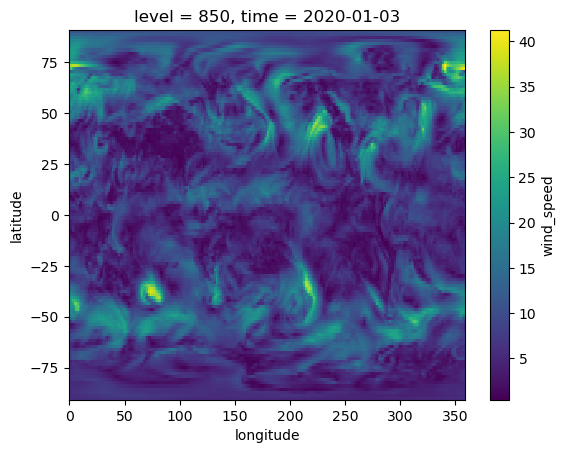

In [193]:
era5_wind.T.sel(time="2020-01-03T00:00:00").plot()

Now, let's calculate twCRPS focusing on performance above the decision threshold 17.2 m/s for the two models.

In [215]:
# First create weights for weighting the grid cells by latitude when we calculate the mean twCRPS. These differ from the threshold weights
lat_weights = create_latitude_weights(ifs_ens_wind.latitude)
tail_tw_crps_for_ensemble(
    ifs_ens_wind, era5_wind, threshold=17.2, tail="upper", ensemble_member_dim="number", weights=lat_weights
)

<xarray.DataArray ()>
array(0.0680429)
Coordinates:
    level                 int32 850
    prediction_timedelta  timedelta64[ns] 2 days

In [210]:
tail_tw_crps_for_ensemble(
    neural_gcm_wind, era5_wind, threshold=17.2, tail="upper", ensemble_member_dim="realization", weights=lat_weights
)

<xarray.DataArray ()>
array(0.33312822)
Coordinates:
    level                 int32 850
    prediction_timedelta  timedelta64[ns] 2 days

The twCRPS was lower (better) for the ECMWF IFS ensemble than the Neural GCM for this week of data.

### Example 2. 850hPa temperatures - focusing on an interval of decision thresholds

Now, suppose that we want to understand which model produces better forecasts of temperatures for decision thresholds between -20 degrees C and -10 degrees C where aircraft icing is most likely to occur. That is, we want to assign a weight of 1 to decision thresholds between -20 and -10, and a weight of 0 elsewhere. This should also take under a minute to download the data.

We will use the `scores.probability.interval_tw_crps_for_ensemble` function.

In [194]:
lead_time = pd.Timedelta("2d")
ifs_ens_temp = ifs_ens.temperature.sel(
    level=850, time=slice("2020-01-01T00:00:00", "2020-01-07T00:00:00"), prediction_timedelta=lead_time
).compute()
neural_gcm_temp = neural_gcm.temperature.sel(
    level=850, time=slice("2020-01-01T00:00:00", "2020-01-07T00:00:00"), prediction_timedelta=lead_time
).compute()
era5_temp = era5.temperature.sel(level=850, time=slice("2020-01-03T00:00:00", "2020-01-09T00:00:00")).compute()

In [195]:
# Update the time coords in the forecast to match up to the observations
ifs_ens_temp = ifs_ens_temp.assign_coords({"time": ifs_ens_temp.time + lead_time})
neural_gcm_temp = neural_gcm_temp.assign_coords({"time": ifs_ens_temp.time + lead_time})

# Convert the temperature to Celsius
ifs_ens_temp -= 273.15
neural_gcm_temp -= 273.15
era5_temp -= 273.15

Let's visualise the observations for the first timestep

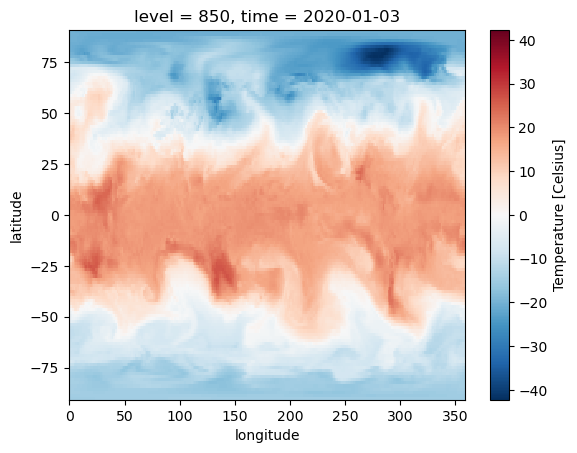

In [217]:
era5_temp.attrs["units"] = "Celsius"
era5_temp.T.sel(time="2020-01-03T00:00:00").plot()

In [211]:
interval_tw_crps_for_ensemble(
    ifs_ens_temp, era5_temp, lower_threshold=-20, upper_threshold=-10, ensemble_member_dim="number", weights=lat_weights
)

<xarray.DataArray ()>
array(0.03216934)
Coordinates:
    level                 int32 850
    prediction_timedelta  timedelta64[ns] 2 days

In [212]:
interval_tw_crps_for_ensemble(
    neural_gcm_temp,
    era5_temp,
    lower_threshold=-20,
    upper_threshold=-10,
    ensemble_member_dim="realization",
    weights=lat_weights,
)

<xarray.DataArray ()>
array(0.15682427)
Coordinates:
    level                 int32 850
    prediction_timedelta  timedelta64[ns] 2 days

In this example, the twCRPS also showed that the ECMWF IFS ensemble performed better than the Neural GCM.

### Example 3. Custom weighting function

While scores has wrapper functions to focus on evaluating "tails" and "intervals", it is also possible to use your own custom weighting function.

Suppose we want the weights to increase linearly with higher decision thresholds and you only have non-negative values(e.g., $w(x) = 2x$). In this case, your chaining function could be $v(x) = x^2$.

Let's work with the wind speed data again. First we need to define the chaining function.

In [213]:
def chaining_func(x):
    return x**2


tw_crps_for_ensemble(
    ifs_ens_wind, era5_wind, ensemble_member_dim="number", chaining_func=chaining_func, weights=lat_weights
)

<xarray.DataArray ()>
array(10.36624932)
Coordinates:
    level                 int32 850
    prediction_timedelta  timedelta64[ns] 2 days

In [214]:
tw_crps_for_ensemble(
    neural_gcm_wind, era5_wind, ensemble_member_dim="realization", chaining_func=chaining_func, weights=lat_weights
)

<xarray.DataArray ()>
array(47.19786567)
Coordinates:
    level                 int32 850
    prediction_timedelta  timedelta64[ns] 2 days

Again, in this case, the ECWMF IFS ensemble performed better than the Neural GCM.

## Things to try next
- The `threshold` arg in `tail_tw_crps_for_ensemble` and the `lower_threshold` and `upper_threshold` args in `interval_tw_crps_for_ensemble` can all take xr.DataArrays instead of floats. Try making the threshold vary with climatology.
- Try your own chaining function based on your own weights in `tw_crps_for_ensemble`.
- Explore the impact of setting `method="fair"` to calculate the [fair version](https://doi.org/10.1002/qj.2270) of the twCRPS.
- Try setting `tail="lower"` in `tail_tw_crps_for_ensemble` to emphasise lower extremes. 

## Further reading
- [Allen, S., Ginsbourger, D., & Ziegel, J. (2023). Evaluating forecasts for high-impact 
    events using transformed kernel scores. SIAM/ASA Journal on Uncertainty 
    Quantification, 11(3), 906-940.](https://doi.org/10.1137/22M1532184) 
- [Allen, S. (2024). Weighted scoringRules: Emphasizing Particular Outcomes 
    When Evaluating Probabilistic Forecasts. Journal of Statistical Software, 
    110(8), 1-26.](https://doi.org/10.18637/jss.v110.i08)